# This file implements Q-Learning for Dataset 3

**Q-Learning and Double Q-Learning Algorithm Description**</br>

**Q-Learning**:

Q-learning is a reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process (MDP).
The algorithm uses a Q-table to store the expected utility of actions taken in specific states.
The agent updates the Q-values based on the rewards received and the expected future rewards (using the Bellman equation).

**Double Q-Learning:**

Double Q-learning addresses the overestimation bias in Q-learning by using two separate Q-tables (Q1 and Q2).
Each Q-table is updated independently, using the other Q-table to estimate the value of the next state.

**Implementation Steps**
1.Preprocess the Data: Load and preprocess the bank dataset.</br>

2.Implement Q-Learning: Set up and train a Q-learning model.</br>

3.Implement Double Q-Learning: Set up and train a Double Q-learning model.</br>

4.Evaluate the Models: Evaluate the performance of both models.</br>

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates
    #(data.duplicated(subset=col_names)).sum()

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers
def outliers_check(data, numeric):
    outliers_sum =[]

    for col in (numeric_cols):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 10 * IQR)) | (data[col] > (Q3 + 10 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
def remove_outliers(data, numeric):
    
    for col in (numeric_cols):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 10 * IQR)) | (data[col] > (Q3 + 10 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data


def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "unknown" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data

    
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

In [5]:
import pandas as pd
data = read_dataset("bank1.csv")

The dataset contains 11,162 rows and 17 columns.
There are no null items in the dataset
There are no duplicates in the dataset


In [6]:
pd.set_option('display.max_columns', None)

(data).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [8]:
#Summary statistics of the dataset
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [9]:
#Class imbalance
data['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [10]:
#Categorize data into numeric and categorical
numeric_cols, categorical_cols = categorize_data(data)

print(f"{len(numeric_cols)} numeric columns and {len(categorical_cols)} categorical columns")

7 numeric columns and 10 categorical columns


In [11]:
#Check for outliers
outliers = outliers_check(data, numeric_cols)

age  0
balance  74
day  0
duration  0
campaign  27
pdays  917
previous  73


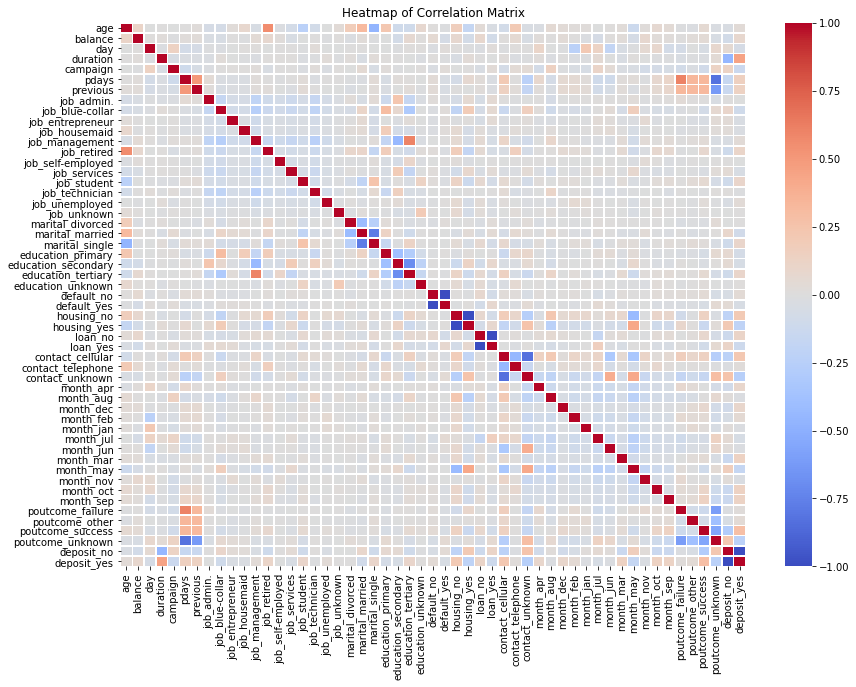

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert categorical variables to numerical using one-hot encoding
data_encoded = pd.get_dummies(data)

# Calculate the correlation matrix
corr = data_encoded.corr()

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [13]:
import numpy as np
#remove outliers
removed_outliers=remove_outliers(data, numeric_cols)
(removed_outliers)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [14]:
removed_special_chars = remove_spec_chars(removed_outliers, categorical_cols)

removed_special_chars

<ipython-input-4-c8f6f2d77743>:89: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [15]:
#replace unknown with mode

removed_unknown = replace_unknown(removed_special_chars, categorical_cols)

removed_unknown

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,unknown,yes
1,56,admin,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,unknown,yes
4,54,admin,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [16]:
#drop "poutcocme column"
categorical_cols.remove('poutcome')

dropped_column = removed_unknown.drop(columns=["poutcome"])

dropped_column

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,deposit
0,59,admin,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,yes
1,56,admin,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,yes
2,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,yes
3,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,yes
4,54,admin,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,no
11158,39,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,no


In [17]:
#One hot encoding

data_encoded = oneHotEncoding(dropped_column, categorical_cols, True)

data_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_bluecollar,job_entrepreneur,job_housemaid,job_management,job_retired,job_selfemployed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,deposit_yes
0,59,2343,5,1042,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,56,45,5,1467,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,41,1270,5,1389,1,-1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,55,2476,5,579,1,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,54,184,5,673,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [18]:
data_encoded.shape

(11162, 37)

In [19]:
# Convert boolean columns from True/False to 1/0
binary_data = data_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Check if the conversion is successful
print(binary_data.head())

   age  balance  day  duration  campaign  pdays  previous  job_bluecollar  \
0   59     2343    5      1042         1     -1         0               0   
1   56       45    5      1467         1     -1         0               0   
2   41     1270    5      1389         1     -1         0               0   
3   55     2476    5       579         1     -1         0               0   
4   54      184    5       673         2     -1         0               0   

   job_entrepreneur  job_housemaid  job_management  job_retired  \
0                 0              0               0            0   
1                 0              0               0            0   
2                 0              0               0            0   
3                 0              0               0            0   
4                 0              0               0            0   

   job_selfemployed  job_services  job_student  job_technician  \
0                 0             0            0               0   
1 

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [21]:
# Define the states and actions
states = binary_data.drop(columns=['deposit_yes']).values
print(states)

[[  59 2343    5 ...    0    0    0]
 [  56   45    5 ...    0    0    0]
 [  41 1270    5 ...    0    0    0]
 ...
 [  32   29   19 ...    0    0    0]
 [  43    0    8 ...    0    0    0]
 [  34    0    9 ...    0    0    0]]


In [22]:
actions = [0, 1]  # 0: no deposit, 1: deposit


In [23]:
# Split data into training and testing
train_states, test_states, train_target, test_target = train_test_split(states, binary_data['deposit_yes'], test_size=0.2, random_state=42)

Accuracy of Q-learning policy: 49.57
Confusion Matrix for Q-learning:
[[572 594]
 [532 535]]
Classification Report for Q-learning:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      1166
           1       0.47      0.50      0.49      1067

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.50      2233
weighted avg       0.50      0.50      0.50      2233



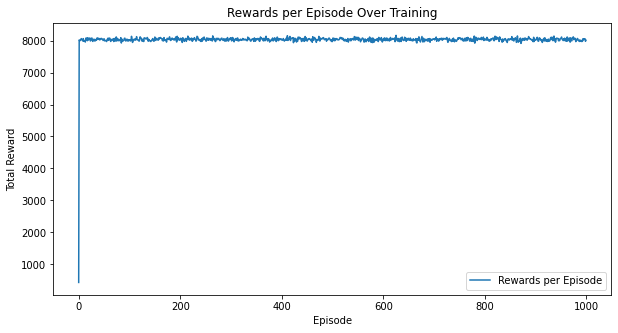

Accuracy of Double Q-learning policy: 49.84
Confusion Matrix for Double Q-learning:
[[582 584]
 [536 531]]
Classification Report for Double Q-learning:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1166
           1       0.48      0.50      0.49      1067

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.50      2233
weighted avg       0.50      0.50      0.50      2233



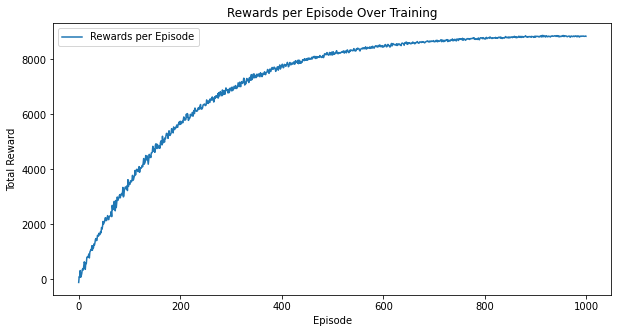

In [31]:

# Initialize Q-table
q_table = np.zeros((train_states.shape[0], len(actions)))

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration factor
rewards_per_episod =[]


# Initialize rewards_per_episode list
rewards_per_episode = []

# Training loop for Q-learning
for episode in range(1000):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table[state_index])

        # Reward is whether the action matches the actual deposit status
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        # Update Q-table
        old_value = q_table[state_index, action]
        next_max = np.max(q_table[state_index])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_index, action] = new_value
    
    # Append total reward for this episode
    rewards_per_episode.append(total_reward)

# Test the learned Q-table
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

# Calculate accuracy
accuracy_rl = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Q-learning policy:", accuracy_rl)

# Print confusion matrix and classification report for Q-learning
print("Confusion Matrix for Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()

# Scale the continuous features
scaler = StandardScaler()
train_states = scaler.fit_transform(train_states)
test_states = scaler.transform(test_states)

# Initialize Q-tables for Double Q-learning
q_table_1 = np.zeros((len(train_states), len(actions)))
q_table_2 = np.zeros((len(train_states), len(actions)))

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
rewards_per_episode = []

# Training loop for Double Q-learning
for episode in range(num_episodes):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table_1[state_index] + q_table_2[state_index])

        next_state_index = np.random.randint(0, len(train_states))
        next_state = train_states[next_state_index]
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        if np.random.rand() < 0.5:
            best_next_action = np.argmax(q_table_1[next_state_index])
            q_table_1[state_index, action] = (1 - alpha) * q_table_1[state_index, action] + alpha * (reward + gamma * q_table_2[next_state_index, best_next_action])
        else:
            best_next_action = np.argmax(q_table_2[next_state_index])
            q_table_2[state_index, action] = (1 - alpha) * q_table_2[state_index, action] + alpha * (reward + gamma * q_table_1[next_state_index, best_next_action])
    
    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Testing the learned policy
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table_1[state_index[0]] + q_table_2[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

accuracy_double_q = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Double Q-learning policy:", accuracy_double_q)

# Print confusion matrix and classification report for Double Q-learning
print("Confusion Matrix for Double Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Double Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()
